In [3]:
%matplotlib inline
from utils import *
from sklearn.model_selection import train_test_split
from deeplabv3p import preprocess_input
PATH = "C:\\Users\jgolb\Desktop\datasets\\"
#PATH = "C://Users/jgolb/Desktop/AI/KITTI/training/"

image_size = (64, 64)

In [4]:
# build model
SegClass = SegModel(PATH, image_size, use_coords = False)
SegClass.set_batch_size(2)
SegClass.set_num_epochs(10)

# = SGD(momentum = 0.8) # Adam()
#opt = SGD(momentum=0.9, decay=0.0005)
#opt = Adam(lr=1e-3, decay=0.995)
opt = RMSprop()
# tiramisu, segnet, unet, deeplab

model = SegClass.create_seg_model(opt, net='tiramisu', load_weights = False, 
                                  multi_gpu = False, to_compile = True)
model.summary()
#model.load_weights('weights/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_61 (Conv2D)              (None, 64, 64, 48)   1344        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, 64, 64, 48)   192         conv2d_61[0][0]                  
__________________________________________________________________________________________________
activation_60 (Activation)      (None, 64, 64, 48)   0           batch_normalization_60[0][0]     
__________________________________________________________________________________________________
conv2d_62 

In [8]:
data_trn_gen_args_mask = dict(preprocessing_function = preprocess_mask,
                              horizontal_flip=True, 
                              rotation_range=5,
                              width_shift_range=0.01, 
                              height_shift_range=0.01,
                              zoom_range=0.2, 
                              validation_split = .1,
                              )

data_trn_gen_args_image = dict(preprocessing_function = preprocess_input,
                               horizontal_flip=True, 
                               rotation_range=5,
                               width_shift_range=0.01, 
                               height_shift_range=0.01,
                               zoom_range=0.2, 
                               validation_split = .1,
                               channel_shift_range = .2
                               )

data_val_gen_args_image = dict(preprocessing_function = preprocess_input, validation_split = .1, horizontal_flip=True)
data_val_gen_args_mask = dict(validation_split = .1, horizontal_flip=True)

train_generator = SegClass.create_generators(data_trn_gen_args_image, data_trn_gen_args_mask, subset = 'training')
valid_generator = SegClass.create_generators(data_val_gen_args_image, data_val_gen_args_mask, subset = 'validation')

Found 10827 images belonging to 1 classes.
Found 10827 images belonging to 1 classes.
Found 1202 images belonging to 1 classes.
Found 1202 images belonging to 1 classes.


In [7]:
data_trn_gen_args_image['preprocessing_function'] = None
#plt.imshow(np.reshape(np.argmax(y[0], axis=-1), image_size))
show_aug_data(train_generator, data_trn_gen_args_image, data_trn_gen_args_mask)

ValueError: too many values to unpack (expected 2)

In [6]:
x,y_true,z = next(train_generator)
y_pred = model.predict(x)

In [30]:
sess = tf.Session()
sess.run(iou)

array([[0.]])

In [11]:
h, cyclr = SegClass.train_generator(model, train_generator=train_generator,
                                    valid_generator = valid_generator,
                                    tf_board = True, mp = False)

Epoch 1/10
3137/5413 [================>.............] - ETA: 13:51 - loss: 3.4569 - Mean_IOU: nan - background_sparse_accuracy: 4.1924e-05 - sparse_accuracy_ignoring_last_label: 0.0644 - foreground_sparse_accuracy: 0.1072 - acc: 0.0618

KeyboardInterrupt: 

In [137]:
pred = model.predict(x)

Epoch 1/3
9000/9000 [==============================] - 38s 4ms/step - loss: 0.6978 - acc: 0.5032
Epoch 2/3
9000/9000 [==============================] - 37s 4ms/step - loss: 0.6940 - acc: 0.5158
Epoch 3/3
9000/9000 [==============================] - 37s 4ms/step - loss: 0.6938 - acc: 0.5120


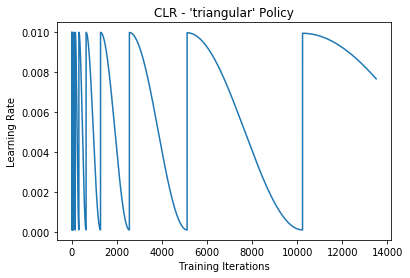

In [16]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input

inp = Input(shape=(15,))                
x = Dense(10, activation='relu')(inp)
x = Dense(1, activation='sigmoid')(x)

model = Model(inp, x)
X = np.random.rand(9000,15)
Y = np.random.randint(0,2,size=9000)
clr_triangular = CyclicLR(base_lr=0.0001, max_lr=0.01,
                      step_size=5, mode = 'cosine', gamma = 0.9999995,
                      scale_mode='iterations', cycle_mult = 2)

model.compile(optimizer=SGD(0.1), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X, Y, batch_size=2, nb_epoch=3, callbacks=[clr_triangular], verbose=1)
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])


### Freezing model

In [ ]:
#models_dir = './models/'
#model_filename = 'model_tf_{}x{}.pb'.format(image_size[0], image_size[1])
#convert_keras_to_pb(deeplab_model, models_dir, model_filename)


In [5]:
frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in deeplab_model.outputs])
tf.train.write_graph(frozen_graph, "weights", "stack128.pb", as_text=False)


INFO:tensorflow:Froze 492 variables.
INFO:tensorflow:Converted 492 variables to const ops.


'weights\\stack128.pb'

#### Create Generators

In [ ]:
data_trn_gen_args_mask = dict(preprocessing_function = preprocess_mask,
                              horizontal_flip=True, rotation_range=45,
                              width_shift_range=0.01, 
                              height_shift_range=0.01,
                              zoom_range=0.2, 
                              validation_split = .2,
                              )

data_trn_gen_args_image = dict(preprocessing_function = preprocess_input,
                               horizontal_flip=True, rotation_range=45,
                               width_shift_range=0.01, 
                               height_shift_range=0.01,
                               zoom_range=0.2, 
                               validation_split = .2,
                               channel_shift_range = .2
                               )

data_val_gen_args_image = dict(preprocessing_function = preprocess_input, validation_split = .2)
data_val_gen_args_mask = dict(validation_split = .2)

train_generator = deeplab_seg.create_generators(data_trn_gen_args_image, data_trn_gen_args_mask, subset = 'training')
valid_generator = deeplab_seg.create_generators(data_val_gen_args_image, data_val_gen_args_mask, subset = 'validation')

In [ ]:
data_trn_gen_args_image['preprocessing_function'] = None

show_aug_data(train_generator, data_trn_gen_args_image, data_trn_gen_args_mask)

## Train Model

In [ ]:
h = deeplab_seg.train_generator(deeplab_model, train_generator=train_generator, 
                                valid_generator = valid_generator, 
                                tf_board = True, mp = True)

### EVALUATION

In [ ]:
classes = [c for c in get_VOC2012_classes().values()]
y_preds = deeplab_model.predict(X_test, batch_size = deeplab_seg.batch_size, verbose=1)
df_test, conf_test, mean_acc_test = evaluate_model(y_preds, y_test, data_from = 'test')

y_preds = deeplab_model.predict(X_valid, batch_size = deeplab_seg.batch_size, verbose=1)
df_valid, conf_valid, mean_acc_valid = evaluate_model(y_preds, y_valid, data_from = 'valid')
df_test['IoU valid'] = df_valid['IoU valid']

if deeplab_seg.coords:
    model_name = 'deeplabv3+ with added coordconv channels'
else:
    model_name = 'deeplabv3+'

plt.figure(figsize=(17,7))
plt.subplot(121)
plot_confusion_matrix(conf_test, classes, normalize=True, 
                      title='Pixel-wise confusion matrix of Test set. Model: '+model_name)
plt.subplot(122)
plot_confusion_matrix(conf_valid, classes, normalize=True, 
                      title='Pixel-wise confusion matrix of Validation set. Model: '+model_name)

print('test mean acc: ', mean_acc_test)
print('validation mean acc: ', mean_acc_valid)
df_test